In [114]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [115]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img
    
image = read_img("./data/dogs-vs-cats/train/cat.10000.jpg")

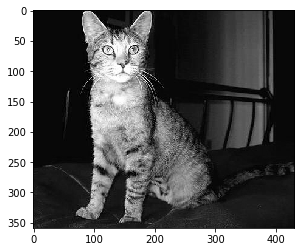

In [116]:
plt.imshow(tf.squeeze(image), cmap=plt.cm.gray)
plt.show()

In [117]:
def gaussian_blur(img, kernel_size, sigma):
    def gaussian_filter(channels = 1):
        kernel_1D = tf.range(-kernel_size // 2 + 1.0, (kernel_size // 2) + 1.0)
        xx, yy = tf.meshgrid(kernel_1D, kernel_1D)
        
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel
    
    gaussian_kernel = gaussian_filter(tf.shape(img)[-1])
    return gaussian_kernel[..., tf.newaxis]

In [154]:
gaussian_kernel = gaussian_blur(image, 3, 3)
gaussian_image = tf.nn.conv2d(image[tf.newaxis, ...], gaussian_kernel, strides=1, padding='SAME')

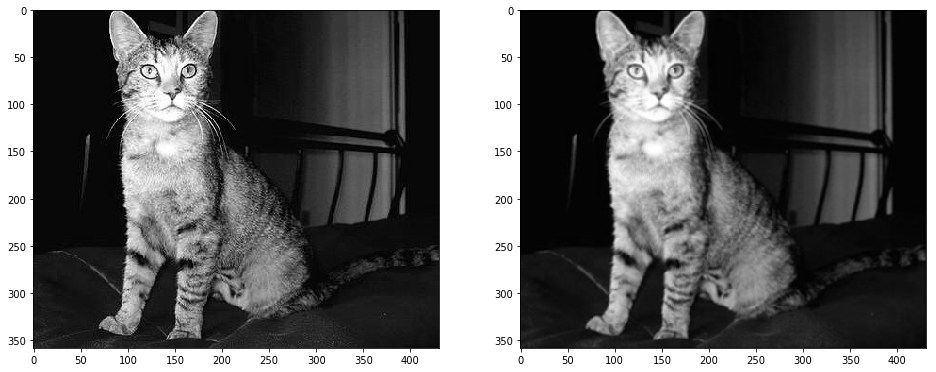

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(tf.squeeze(image), cmap=plt.cm.gray)
ax[1].imshow(tf.squeeze(gaussian_image), cmap=plt.cm.gray)
plt.show()

In [227]:
def sobel_detection(image, kernel):
    kernel_x = kernel[..., tf.newaxis, tf.newaxis] # Assumption is image will be always in grayscale
    kernel_y = tf.transpose(kernel)[..., tf.newaxis, tf.newaxis]
    
    grad_x = tf.nn.conv2d(input=image, filters=kernel_x, strides=1, padding='SAME')
    grad_y = tf.nn.conv2d(input=image, filters=kernel_y, strides=1, padding='SAME')
    
    gradient_magnitude = tf.sqrt(tf.square(grad_x) + tf.square(grad_y))
    gradient_magnitude *= 255.0 / tf.reduce_max(gradient_magnitude)
    
    return grad_x, grad_y, gradient_magnitude

In [228]:
sobel_kernel = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)

grad_x, grad_y, magnitude = sobel_detection(gaussian_image, sobel_kernel)

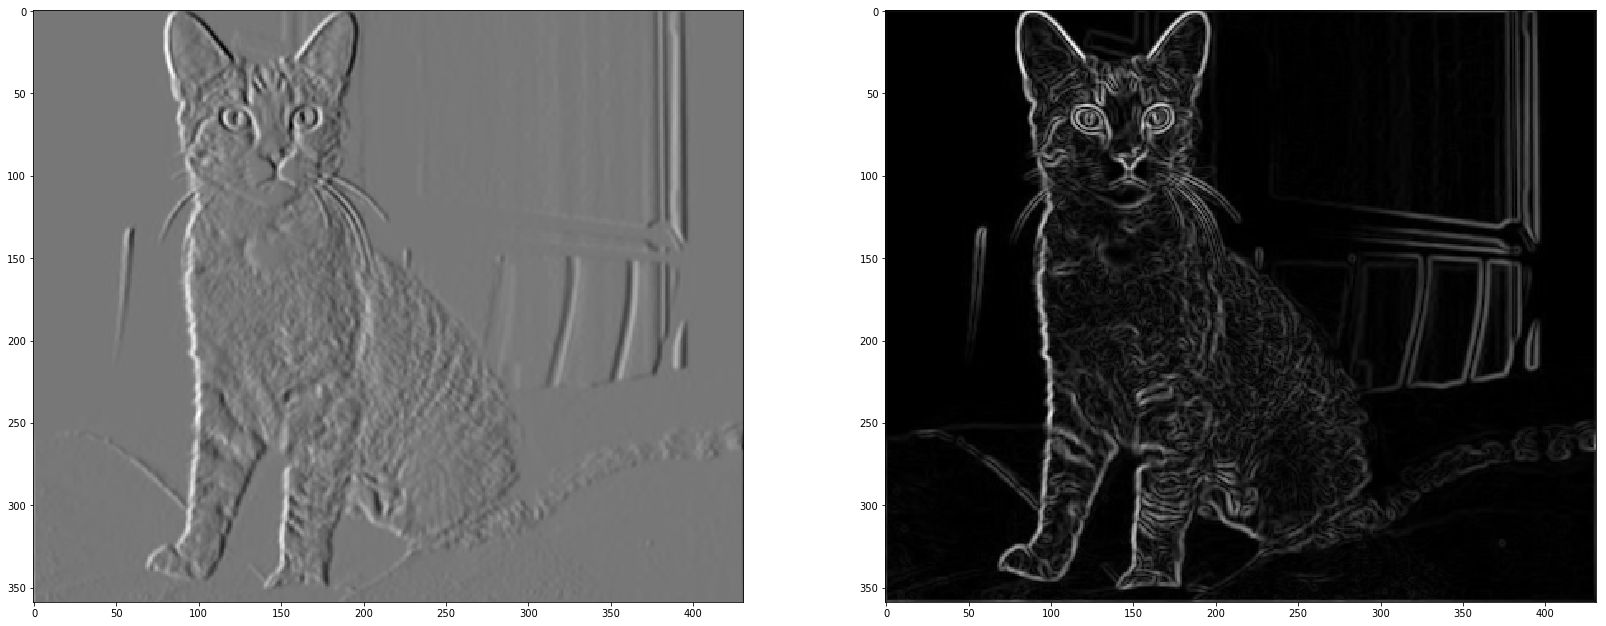

In [233]:
fig, ax = plt.subplots(1, 2, figsize=(28, 28))
ax[0].imshow(tf.squeeze(grad_x), cmap=plt.cm.gray)
ax[1].imshow(tf.squeeze(magnitude), cmap=plt.cm.gray)
plt.show()